In [1]:
import argparse
import os
import re
import random
from glob import glob


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm, trange

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [4]:
import json
from setproctitle import setproctitle
from hanspell import spell_checker


In [5]:
parser = argparse.ArgumentParser()
parser.add_argument('--proccess_name', default='seq2seq_bahdanau_mario')
parser.add_argument('--data_path', default='s-kr/fine-tune/dataset/kspon_gec_dataset')
parser.add_argument('--klec_path', default='./save')
parser.add_argument('--devices', default='1')
parser.add_argument('--max_len', default=1000)
args = parser.parse_args([])

In [6]:
# process 이름 설정
setproctitle(args.proccess_name)


In [7]:
# cuda device 설정
os.environ["CUDA_VISIBLE_DEVICES"] = args.devices
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
print('Kind of Device:', device)
print('Count of available GPUs:', torch.cuda.device_count())
print('Current cuda Device:', torch.cuda.current_device())

Kind of Device: cuda
Count of available GPUs: 1
Current cuda Device: 0


In [9]:
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [10]:
a="안태형 최고최고!!"
for i in list(a):
    if i not in r'[^~?!\s+]':
        print(i)

안
태
형
 
최
고
최
고


In [11]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'SOS', 1: 'EOS'}
        self.n_words = 2
        
    def addSentence(self, sentence):
        # for word in sentence.split(' '):
        #     self.addWord(word)
        for word in list(sentence):
            if word not in r'[^~?!\s+]':
                # print(word)
                self.addWord(word)
    
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
            


In [12]:
def normalizeString(s):
    s = re.sub(r"[^가-힣,.\s]+",'', s) # ,.?! 호함시킬걸
    return s

In [13]:
def readLangs(lang1, lang2, reverse=False):
    print('Reading lines...')
    # tsv read
    pairs = []
    data_list=glob(os.path.join(args.data_path, '*.tsv'))
    for data in tqdm(data_list):
        df = pd.read_csv(data, sep='\t', encoding='utf-8')
        # 'form' 칼럼에 일부 데이터(3개) NaN(Not a Number: 표현 불가능한 수치형) 결측치 존재하여 삭제
        df = df.dropna()
        # df = df[:1000] # 1000 개만?
        # 모든 줄을 분리하고 정규화

        for _, row in df.iterrows():
            # print(row)
            form = row['form']
            corrected_form = row['corrected_form']
            pair = [normalizeString(form), normalizeString(corrected_form)]
            pairs.append(pair) # pairs는 form과 cor을 한 리스트에 넣어둔 리스트임. 2차원

          #  if len(pairs) >=500000: # 전체 학습 데이터수량
              #  break
    print('Dataset length :',len(pairs)) 
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)


    return input_lang, output_lang, pairs

In [14]:
def prepareData(lang1, lang2, reverse=False):
    max_len = 0

    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        
        if len(pair[0]) > max_len:
            max_len = len(pair[0])
        if len(pair[1]) > max_len:
            max_len = len(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs, max_len



input_lang, output_lang, pairs, max_len = prepareData('form', 'corrected_form', False)
print(random.choice(pairs))
print('max_len :', max_len)

# pair

Reading lines...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [01:34<00:00,  1.52s/it]


Dataset length : 612411
Counted words:
form 1862
corrected_form 2269
['음 그거래 그럼 심화해야지 뭐 일단 애들 돈만 좀 어울리 주고 어 그렇게 해서 아무튼 칠 월 지월 다에 가자고', '음 그래 그럼 시마이 해야지 뭐, 일단 애들 돈만 좀 올려주고 어 그렇게 해서 아무튼 월 전에는 내려가자고.']
max_len : 322


In [15]:
import json
import os

form_vocab_path = os.path.join(args.klec_path, 'form_vocab.json')
with open(form_vocab_path, 'w') as vocab_file1:
    json.dump(input_lang.index2word, vocab_file1)

cform_vocab_path = os.path.join(args.klec_path, 'cform_vocab.json')
with open(cform_vocab_path, 'w') as vocab_file2:
    json.dump(output_lang.index2word, vocab_file2)


In [16]:
def indexesFromSentence(lang, sentence):
    # return [lang.word2index[word] for word in sentence.split(' ')]
    return [lang.word2index[word] for word in list(sentence) if word not in r'[^~?!\s+]']


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0]) 
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


# def targetToSentence(targets_list , id2char):
    
#     sentence=""
    
#     for i in targets_list:
#         sentence += id2char[int(n)]
        
#     return sentence
        


### https://wikidocs.net/159523 참고한 encoder, decoder

In [17]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size,n_layers=1):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)

    def forward(self, inputs, hidden):
        # Embed input words
        embedded = self.embedding(inputs).view([-1, 1, 256])
        # Pass the embedded word vectors into LSTM and return all outputs
        
        output, hidden = self.lstm(embedded, hidden)

        # print('output.size : ', output.size)
        # print('hidden.size : ', hidden.size) 
        
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

In [18]:
class BahdanauDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, drop_prob=0.1):
        super(BahdanauDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.drop_prob = drop_prob

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        self.fc_hidden = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.fc_encoder = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.weight = nn.Parameter(torch.FloatTensor(1, hidden_size))
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.drop_prob)
        self.lstm = nn.LSTM(self.hidden_size*2, self.hidden_size, batch_first=True)
        self.classifier = nn.Linear(self.hidden_size, self.output_size)

        
    def forward(self, inputs, hidden, encoder_outputs):
        encoder_outputs = encoder_outputs.squeeze()
        # Embed input words
        embedded = self.embedding(inputs).view(1, -1)
        embedded = self.dropout(embedded)

        # Calculating Alignment Scores
        x = torch.tanh(self.fc_hidden(hidden[0])+self.fc_encoder(encoder_outputs))
        alignment_scores = x.bmm(self.weight.unsqueeze(2))  

        # Softmaxing alignment scores to get Attention weights
        attn_weights = F.softmax(alignment_scores.view(1,-1), dim=1)

        # Multiplying the Attention weights with encoder outputs to get the context vector
        context_vector = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        # Concatenating context vector with embedded input word
        output = torch.cat((embedded, context_vector[0]), 1).unsqueeze(0)
        # Passing the concatenated vector as input to the LSTM cell
        output, hidden = self.lstm(output, hidden)
        # Passing the LSTM output through a Linear layer acting as a classifier
        output = F.log_softmax(self.classifier(output[0]), dim=1)
        return output, hidden, attn_weights
    
    
    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

In [19]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor,
          encoder, decoder,
          encoder_optimizer, decoder_optimizer,
          criterion, max_length=max_len):
    
    encoder_hidden = encoder.initHidden()
    # print('encoder_hidden.shape', encoder_hidden)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    # print('encoder_outputs.shape', encoder_outputs.shape)
    
    loss = 0
    for fr in range(input_length):
        # print('input_tensor[fr].shape', input_tensor[fr].shape)
        # print('encoder(input_tensor[fr], encoder_hidden)', encoder(input_tensor[fr], encoder_hidden))
        encoder_output, encoder_hidden = encoder(input_tensor[fr], encoder_hidden)
        # print('encoder_output.shape', encoder_output.shape)
        encoder_outputs[fr] = encoder_output[0, 0]
    
    decoder_input = torch.tensor([[SOS_token]], device=device)
    
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing 포함: 목표를 다음 입력으로 전달
        for cfr in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            
            loss += criterion(decoder_output, target_tensor[cfr]) # decoder_output = pred
            decoder_input = target_tensor[cfr]
 
    else:
        # Teacer forcing 미포함: 자신의 예측을 다음 입력을 사용
        for cfr in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach() # 입력으로 사용할 부분을 히스토리에서 분리
            
            loss += criterion(decoder_output, target_tensor[cfr])
            if decoder_input.item() == EOS_token:
                break
                
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return (decoder_output, loss.item() / target_length)

### 현재 시간과 진행률%을 고려해 경과된 시간과 남은 예상 시간을 출력하는 헬퍼 함수

In [20]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

### 여러 번 train 을 호출하며 때로는 진행률 (예제의 %, 현재까지의 예상 시간)과 평균 손실을 출력

In [21]:
from multiprocessing import Pool
import time
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor



def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time() # batch size * iteration = 전체 데이터수
    plot_losses = []
    y_pred=[]
    print_loss_total = 0 # print_every 마다 초기화
    plot_loss_total = 0 # plot_every 마다 초기화
    
    
    target_list=[]
    
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorFromPair(random.choice(pairs)) for i in range(n_iters)]
    
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.NLLLoss(size_average=False) 
    
    # 여기에 에폭 기능 추가 필요
    
    for iter in trange(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0] 
        target_tensor = training_pair[1]

        pred, loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        
        # print('loss : ',loss)
        
        y_pred.append(pred)
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            
            plot_loss_total = 0
            print('Average loss : %s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters), iter, iter / n_iters * 100, print_loss_avg))
        
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
    return (plot_losses, y_pred)

In [22]:
hidden_size = 256 
encoder1 = EncoderLSTM(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = BahdanauDecoder(hidden_size, output_lang.n_words).to(device)

# trainIters(encoder1, attn_decoder1, 75000, print_every=5000)


print(encoder1)
print(attn_decoder1)

EncoderLSTM(
  (embedding): Embedding(1862, 256)
  (lstm): LSTM(256, 256)
)
BahdanauDecoder(
  (embedding): Embedding(2269, 256)
  (fc_hidden): Linear(in_features=256, out_features=256, bias=False)
  (fc_encoder): Linear(in_features=256, out_features=256, bias=False)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(512, 256, batch_first=True)
  (classifier): Linear(in_features=256, out_features=2269, bias=True)
)


In [23]:
plot_losses, y_pred = trainIters(encoder1, attn_decoder1, 75000, print_every=5000)
# # loss에서 nan 뜨면 kernel restart



/opt/conda/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  7%|███████                                                                                                  | 5001/75000 [11:23<2:06:33,  9.22it/s]

Average loss : 11m 33s (- 161m 44s) (5000 6%) 3.7233


 13%|█████████████▊                                                                                          | 10000/75000 [23:08<2:17:16,  7.89it/s]

Average loss : 23m 18s (- 151m 29s) (10000 13%) 7.0323


 20%|████████████████████▊                                                                                   | 15001/75000 [34:56<2:43:10,  6.13it/s]

Average loss : 35m 6s (- 140m 26s) (15000 20%) 10.0381


 27%|███████████████████████████▋                                                                            | 20000/75000 [46:49<1:38:58,  9.26it/s]

Average loss : 46m 59s (- 129m 14s) (20000 26%) 12.6721


 33%|██████████████████████████████████▋                                                                     | 25001/75000 [58:57<2:22:05,  5.86it/s]

Average loss : 59m 7s (- 118m 15s) (25000 33%) 14.9868


 40%|████████████████████████████████████████▊                                                             | 30000/75000 [1:11:04<2:12:55,  5.64it/s]

Average loss : 71m 14s (- 106m 51s) (30000 40%) 17.1328


 47%|███████████████████████████████████████████████▌                                                      | 35001/75000 [1:22:55<1:43:06,  6.47it/s]

Average loss : 83m 5s (- 94m 57s) (35000 46%) 19.1337


 53%|███████████████████████████████████████████████████████▍                                                | 40001/75000 [1:35:05<42:42, 13.66it/s]

Average loss : 95m 15s (- 83m 20s) (40000 53%) 21.0748


 60%|█████████████████████████████████████████████████████████████▏                                        | 45001/75000 [1:47:15<1:33:36,  5.34it/s]

Average loss : 107m 25s (- 71m 37s) (45000 60%) 22.9413


 67%|█████████████████████████████████████████████████████████████████████▎                                  | 50001/75000 [1:59:13<33:07, 12.58it/s]

Average loss : 119m 23s (- 59m 41s) (50000 66%) 24.7717


 73%|████████████████████████████████████████████████████████████████████████████▎                           | 55000/75000 [2:11:05<41:10,  8.09it/s]

Average loss : 131m 15s (- 47m 43s) (55000 73%) 26.5634


 80%|███████████████████████████████████████████████████████████████████████████████████▏                    | 60001/75000 [2:23:01<34:50,  7.18it/s]

Average loss : 143m 11s (- 35m 47s) (60000 80%) 28.3123


 87%|██████████████████████████████████████████████████████████████████████████████████████████▏             | 65000/75000 [2:34:45<32:04,  5.20it/s]

Average loss : 154m 55s (- 23m 50s) (65000 86%) 30.0677


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████       | 70000/75000 [2:47:11<14:42,  5.66it/s]

Average loss : 167m 21s (- 11m 57s) (70000 93%) 31.8112


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 75000/75000 [2:59:09<00:00,  6.98it/s]

Average loss : 179m 19s (- 0m 0s) (75000 100%) 33.4757


In [24]:
plot_losses

[5.115086273414005,
 4.476462042599552,
 4.2527270813619005,
 4.2126880365815955,
 4.1915090741122825,
 3.9406931896781066,
 3.965471253684188,
 3.9850195701437614,
 3.840318416613247,
 3.839075392331164,
 3.92948565566157,
 3.9722173804566374,
 3.8283695501571433,
 3.831113484466767,
 3.8079111226524156,
 3.7130149005770807,
 3.6748745157821032,
 3.7208597004224733,
 3.747474725326317,
 3.7776195026191584,
 3.7261658579425485,
 3.6929747556095434,
 3.4864625405960656,
 3.6203019345076175,
 3.7974081723674917,
 3.645011926728793,
 3.5181272516509186,
 3.5677319075501934,
 3.376069788046914,
 3.5405125654850393,
 3.726844262608811,
 3.6592520087077367,
 3.5440972696357598,
 3.537883748358725,
 3.4293206876092217,
 3.702299413338111,
 3.479685008105445,
 3.4718878134741034,
 3.35792137681505,
 3.535056184205913,
 3.416538091651948,
 3.5657452282519246,
 3.5215475409696317,
 3.597511433395317,
 3.644921205125438,
 3.566617498615278,
 3.432433652629123,
 3.337148406923707,
 3.4322501379228

<Figure size 432x288 with 0 Axes>

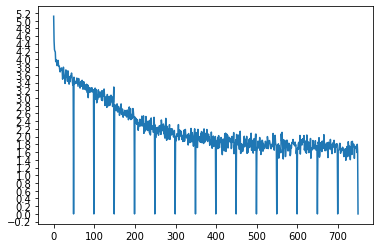

In [25]:
showPlot(plot_losses)

In [26]:
y_pred

[tensor([[-7.7984, -7.6460, -7.7156,  ..., -7.6000, -7.8471, -7.7791]],
        device='cuda:0', grad_fn=<LogSoftmaxBackward>),
 tensor([[-7.8067, -7.6391, -7.6607,  ..., -7.7664, -7.7153, -7.8503]],
        device='cuda:0', grad_fn=<LogSoftmaxBackward>),
 tensor([[-7.8450, -7.5354, -7.7701,  ..., -7.7028, -7.7339, -7.6587]],
        device='cuda:0', grad_fn=<LogSoftmaxBackward>),
 tensor([[-7.6479, -7.5344, -7.7424,  ..., -7.7626, -7.7189, -7.7393]],
        device='cuda:0', grad_fn=<LogSoftmaxBackward>),
 tensor([[-7.8073, -7.3289, -7.7700,  ..., -7.5796, -7.8297, -7.7760]],
        device='cuda:0', grad_fn=<LogSoftmaxBackward>),
 tensor([[-7.8633, -7.1437, -7.3841,  ..., -7.4963, -7.5744, -7.6237]],
        device='cuda:0', grad_fn=<LogSoftmaxBackward>),
 tensor([[-7.8941, -6.9599, -7.2116,  ..., -7.5162, -7.5526, -7.6667]],
        device='cuda:0', grad_fn=<LogSoftmaxBackward>),
 tensor([[-7.9771, -6.8427, -7.0592,  ..., -7.4464, -7.6306, -7.6273]],
        device='cuda:0', grad_fn

In [27]:
def evaluate(encoder, decoder, sentence, max_length=args.max_len):
    
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

### matplotlib로 학습 중에 저장된 손실 값 plot_losses 의 배열을 사용하여 도식화

In [28]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1,
    sentence="알겠어")
# plt.matshow(attentions.numpy())

In [29]:
output_words

['알', '겠', '어', '.', '<EOS>']

### 학습 세트에 있는 임의의 문장을 평가하고 입력, 목표 및 출력을 출력하여 주관적인 품질 판단

In [30]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('form ->', pair[0])
        print('corrected form ->', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        # print('output_words: ',output_words)
        output_sentence = ''.join(output_words)
        output_sentence = output_sentence.replace('<EOS>','')
        # 띄어쓰기 교정기
        # spelled_sent = spell_checker.check(output_sentence)
        # hanspell_sent = spelled_sent.checked
        # print('output ->', hanspell_sent)
        
        print('output ->', output_sentence)

        print('')

In [31]:
evaluateRandomly(encoder1, attn_decoder1)

form -> 아휴 아왜 그걸 불로 더 신난 노래도 많은데
corrected form -> 아휴. 아, 왜 그걸 불러, 더 신나는 노래도 많은데.
output -> 아휴 아  걸 불   불더 신신 노래도 많은데

form -> 맥폭 사라 진짜
corrected form -> 맥북 사라 진짜.
output -> 맥빈 사람  짜짜

form -> 응 살찌겠네 더 아니야 폭식 안 하는 하는 것보다 이게 밥 먹는 게 날 거야
corrected form -> 응. 살찌겠네 더. 아냐 폭식 안 하는 하는 것보다 이게 밥 먹는 게 날 거야.
output -> 응. 살찌겠네. 더 아니야  식 안 하는 것 는 하는 것  게         거야.

form -> 초밥
corrected form -> 초밥
output -> 초밥밥

form -> 자기 과거 얘기 한 것처럼 쫌 진짜 좀 대단한 일이 맛있었는데
corrected form -> 자기 과거 얘기에 한 거처럼 좀 진짜 좀 대단한 일이 마 있었는데
output -> 자기 과거 얘기 한처 것처럼 쫌       단     있는데데데데

form -> 어떤 얘긴지 알 거 같애 잘 잘 깠다는 얘기구나
corrected form -> 어떤 얘긴지 알 거 같애. 잘 잘 깠다는 얘기구나
output -> 어떤 얘기지 알 거 같애. 잘 잘 다 잘  다 

form -> 무슨 골짜이 뭐였는데
corrected form -> 무슨 골짜기 뭐였는데
output -> 무슨 골짜이 뭐였는데

form -> 전화할 때 어쩐지 소리가 안 들리더라고 그래서 그거 때매 십만 원밖에 못 받았어
corrected form -> 전화할 때 어쩐지 소리가 안 들리더라고. 그래서 그것 때매 만원 밖에 못 받았어.
output -> 전화할 때 어 지 지소 안 들들이라고 그래서 그거 때 때 때  매받았어.

form -> 그 애들한테 막 애들 앞에서는 안 하고 막 깨 앞 깨한테 니 나 너 나덕보에 공교 올라간 걸 내가 수비 내려와서 그니까 막 애들 앞에서는
corr

In [32]:
from hanspell import spell_checker

sent = "이제어쩌면좋죠?"
spelled_sent = spell_checker.check(sent)
hanspell_sent = spelled_sent.checked
print(hanspell_sent)

이제 어쩌면 좋죠?


In [33]:
a=['알', '겠', '어', '<EOS>']
a=''.join(a)
a=a.replace('<EOS>','')
a

'알겠어'

In [34]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    
    output_words=''.join(output_words)
    output_words = output_words.replace('<EOS>','')
    print('input =', input_sentence)
    print('output =', output_words)
    # showAttention(input_sentence, output_words, attentions)
    
    return output_words
    
evaluateAndShowAttention("이제 어쩌면 좋죠")


input = 이제 어쩌면 좋죠
output = 이제 어쩌면 좋죠.


'이제 어쩌면 좋죠.'

In [35]:
dd=pd.read_csv('s-kr/fine-tune/dataset/ktalk_results/gec_ktalk_result.csv',
               encoding='cp949', index_col='Unnamed: 0')

text=dd.head(10)
text

,form,corrected_form,t5_form
0,기존점을 쓰고 그것에 관한 관점인가 감상인가 아닌가 이런 걸 구별하는 연습도 해보셔...,기준점을 주고 그것에 관한 관점인가 감상인가 아닌가 이런 걸 구별하는 연습도 해 보...,기존점을 쓰고 그것에 관한 관점인가 감상인가 아닌가 이런 걸 구별하는 연습도 해보셔...
1,킬부도 시원을 하면 안 돼요,필부도 시건을 하면 안 돼요.,킬부도 시원을 하면 안 돼요?
2,현강의 문이 발짝 열셨습니다 서 일 이 강 얻어셨나요 복수를 잘 하셨나요 저 일강을...,삼강의 문이 활짝 열렸습니다. 자 일 이강 어떠셨나요 복습 잘 하셨나요 자 일강을 ...,현강의 문이 발짝 열셨습니다. 서 일 이 강 얻어셨나요? 복수를 잘 하셨나요? 저 ...
3,화자가 누군가에게 말을 걷낸다는건 내 말을 들어주는 사람이 있는 거죠 그래서 이걸 ...,화자가 누군가에게 말을 건넨다는 건 내 말을 들어주는 사람이 있는 거죠 그래서 이걸...,화자가 누군가에게 말을 걷낸다는 건 내 말을 들어주는 사람이 있는 거죠. 그래서 이...
4,길게 써있는데요 아까 제목에서 봤던 거가 굉장히 비슷한 내용기죠 새,길게 쓰여있는데요. 아까 제목에서 봤던 것과 굉장히 비슷한 내용이죠 세.,길게 써있는데요. 아까 제목에서 봤던 거가 굉장히 비슷한 내용이죠. 세
5,계속 여러 번 나오고 있어요 이거 쉬 안 좋은 문제점이거든요 그것 을 보안하기위에 ...,계속 여러 번 나오고 있어요. 이것이 안 좋은 문제점이거든요. 그것을 보완하기 위해...,계속 여러 번 나오고 있어요. 이거 쉬 안 좋은 문제점이거든요. 그것 을 보완하기 ...
6,그다음 기자 기자의 질문 어린 석은 사람을 높이 평가이 이것을 긍정적으로 바라봤죠 ...,그다음 기자 기자의 질문 어리석은 사람을 높이 평가한 이유 이것을 긍정적으로 바라봤...,그다음 기자? 기자의 질문. 어린 석은 사람을 높이 평가. 이것을 긍정적으로 바라봤...
7,자 반달리즘에 경향을 어떻게 이해한다고 했죠 그래서 뭔가 기존의 것에서 벗어나려고 ...,자 반달리즘의 경향을 어떻게 이해한다고 했죠 그렇죠 뭔가 기존의 것에서 벗어나려고 ...,자 반달리즘에 경향을 어떻게 이해한다고 했죠? 그래서 뭔가 기존의 것에서 벗어나려고...
8,칼처럼 비정한 것이기 때문입니다 지문에 있었던 내용 그대로 가지고 왔거든요 적절하구요,칼처럼 비정한 것이기 때문입니다. 지문에 있었던 내용 그대로 가지고 왔거든요 적절하고요.,칼처럼 비정한 것이기 때문입니다. 지문에 있었던 내용 그대로 가지고 왔거든요. 적절...
9,교과서에 나와 있는 지문이 이것보다 훨씬 길고 이 앞에 작품이 하나 더 있어요 그죠,교과서에 나와 있는 지문이 이것보다 훨씬 길고 이 앞에 작품이 하나 더 있어요 그죠.,교과서에 나와 있는 지문이 이것보다 훨씬 길고 이 앞에 작품이 하나 더 있어요. 그죠?


In [36]:
text['lstm_bada']=list(map(lambda x:evaluateAndShowAttention(x), text['form']))
text

input = 기존점을 쓰고 그것에 관한 관점인가 감상인가 아닌가 이런 걸 구별하는 연습도 해보셔야 합니다
output = 기존점을 쓰고 그것에 관 인 점 관 인 인 인                         니
input = 킬부도 시원을 하면 안 돼요
output = 깔부도 시원을 하면 안 돼.
input = 현강의 문이 발짝 열셨습니다 서 일 이 강 얻어셨나요 복수를 잘 하셨나요 저 일강을 통해서요 우리 언어에 성격에 대해서 배웠어요 서 오늘 이 시간에는요 일 이강에서 언어에 성격과 그 문제 적금까지 해결했다면 언어에서 좀 더 좁혀서 한국어 국어에 특질은 어떤 게 있는지 같이 살펴보도록 하겠습니다 저 살펴보기 전에 항상 운리
output = 현강의 문이 발컬 열셨습 다 서 일                                                                                                                                                             .
input = 화자가 누군가에게 말을 걷낸다는건 내 말을 들어주는 사람이 있는 거죠 그래서 이걸 바꾸 말하면 총
output = 화자가 누군가 게 말을    는 는                                  .
input = 길게 써있는데요 아까 제목에서 봤던 거가 굉장히 비슷한 내용기죠 새
output = 길게 써 는 요 까                           새새
input = 계속 여러 번 나오고 있어요 이거 쉬 안 좋은 문제점이거든요 그것 을 보안하기위에 이 정도로 반복하는데도 못 알아들면 안 돼요
output = 계속 여러 나오고 있어어                      거                                 안
input = 그다음 기자 기자의 질문 어린 석은 사람을 높이 평가이 이것을 긍정적으로 바라봤죠 그 이후로 질문했어요 어린 석은 사

/tmp/ipykernel_23979/2646065310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['lstm_bada']=list(map(lambda x:evaluateAndShowAttention(x), text['form']))


,form,corrected_form,t5_form,lstm_bada
0,기존점을 쓰고 그것에 관한 관점인가 감상인가 아닌가 이런 걸 구별하는 연습도 해보셔...,기준점을 주고 그것에 관한 관점인가 감상인가 아닌가 이런 걸 구별하는 연습도 해 보...,기존점을 쓰고 그것에 관한 관점인가 감상인가 아닌가 이런 걸 구별하는 연습도 해보셔...,기존점을 쓰고 그것에 관 인 점 관 인 인 인 ...
1,킬부도 시원을 하면 안 돼요,필부도 시건을 하면 안 돼요.,킬부도 시원을 하면 안 돼요?,깔부도 시원을 하면 안 돼.
2,현강의 문이 발짝 열셨습니다 서 일 이 강 얻어셨나요 복수를 잘 하셨나요 저 일강을...,삼강의 문이 활짝 열렸습니다. 자 일 이강 어떠셨나요 복습 잘 하셨나요 자 일강을 ...,현강의 문이 발짝 열셨습니다. 서 일 이 강 얻어셨나요? 복수를 잘 하셨나요? 저 ...,현강의 문이 발컬 열셨습 다 서 일 ...
3,화자가 누군가에게 말을 걷낸다는건 내 말을 들어주는 사람이 있는 거죠 그래서 이걸 ...,화자가 누군가에게 말을 건넨다는 건 내 말을 들어주는 사람이 있는 거죠 그래서 이걸...,화자가 누군가에게 말을 걷낸다는 건 내 말을 들어주는 사람이 있는 거죠. 그래서 이...,화자가 누군가 게 말을 는 는 ...
4,길게 써있는데요 아까 제목에서 봤던 거가 굉장히 비슷한 내용기죠 새,길게 쓰여있는데요. 아까 제목에서 봤던 것과 굉장히 비슷한 내용이죠 세.,길게 써있는데요. 아까 제목에서 봤던 거가 굉장히 비슷한 내용이죠. 세,길게 써 는 요 까 새새
5,계속 여러 번 나오고 있어요 이거 쉬 안 좋은 문제점이거든요 그것 을 보안하기위에 ...,계속 여러 번 나오고 있어요. 이것이 안 좋은 문제점이거든요. 그것을 보완하기 위해...,계속 여러 번 나오고 있어요. 이거 쉬 안 좋은 문제점이거든요. 그것 을 보완하기 ...,계속 여러 나오고 있어어 거 ...
6,그다음 기자 기자의 질문 어린 석은 사람을 높이 평가이 이것을 긍정적으로 바라봤죠 ...,그다음 기자 기자의 질문 어리석은 사람을 높이 평가한 이유 이것을 긍정적으로 바라봤...,그다음 기자? 기자의 질문. 어린 석은 사람을 높이 평가. 이것을 긍정적으로 바라봤...,그다음 기자 기자 사 ...
7,자 반달리즘에 경향을 어떻게 이해한다고 했죠 그래서 뭔가 기존의 것에서 벗어나려고 ...,자 반달리즘의 경향을 어떻게 이해한다고 했죠 그렇죠 뭔가 기존의 것에서 벗어나려고 ...,자 반달리즘에 경향을 어떻게 이해한다고 했죠? 그래서 뭔가 기존의 것에서 벗어나려고...,자 반 리 경 향을 어 별 ...
8,칼처럼 비정한 것이기 때문입니다 지문에 있었던 내용 그대로 가지고 왔거든요 적절하구요,칼처럼 비정한 것이기 때문입니다. 지문에 있었던 내용 그대로 가지고 왔거든요 적절하고요.,칼처럼 비정한 것이기 때문입니다. 지문에 있었던 내용 그대로 가지고 왔거든요. 적절...,칼처럼 비정한 것이기 때문이 다 요
9,교과서에 나와 있는 지문이 이것보다 훨씬 길고 이 앞에 작품이 하나 더 있어요 그죠,교과서에 나와 있는 지문이 이것보다 훨씬 길고 이 앞에 작품이 하나 더 있어요 그죠.,교과서에 나와 있는 지문이 이것보다 훨씬 길고 이 앞에 작품이 하나 더 있어요. 그죠?,교과서에 나와 있는 지문이 이것 다 앞 길 다 .어


In [37]:
import Levenshtein as Lev

def cal_cer(input_text: str, output_text: str) -> float:
    input_text = input_text.replace(' ', '')
    output_text = output_text.replace(' ', '')
    
    dist = Lev.distance(output_text, input_text)
    length = len(input_text)
    
    # assert length==0 ,'시발'
    return dist / length


# label_data=['기준점을 주고 그것에 관한 관점인가 감상인가 아닌가 이런 걸 구별하는 연습도 해 보셔야 합니다.']
# results=['기존점을 쓰고 그것에 관한 관점인가 감상인가 아닌가 이런 걸 구별하는 연습도 해보셔야 합니다.']


# cer 측정
def cal_acc(results:list, label_data:list) -> float:
    total_cer = 0.0
    for naver_data, answer_data in zip(results, label_data):
        cer = cal_cer(answer_data, naver_data)
        total_cer += cer

    result_cer = total_cer / len(results)
    acc=(1-result_cer) * 100
    return round(acc,2)

# print("Test CER: {:.3f}".format(result_cer))
# print("Test ACC: {:.3f}".format((1-result_cer) * 100))
# print(cal_acc(results, label_data))

lis=[]
for i in trange(len(text)):
    
    label_data=[text['corrected_form'][i]]
    results=[text['lstm_bada'][i]]
    # print('1 :',label_data,results)
    lis.append(cal_acc(results, label_data))
    # print('2:',lis)
text['acc']=lis

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10667.10it/s]
/tmp/ipykernel_23979/8404822.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['acc']=lis


In [38]:
text.to_csv(f'./장표정리_list2.tsv',encoding='utf-8',sep='\t')

In [39]:
text

,form,corrected_form,t5_form,lstm_bada,acc
0,기존점을 쓰고 그것에 관한 관점인가 감상인가 아닌가 이런 걸 구별하는 연습도 해보셔...,기준점을 주고 그것에 관한 관점인가 감상인가 아닌가 이런 걸 구별하는 연습도 해 보...,기존점을 쓰고 그것에 관한 관점인가 감상인가 아닌가 이런 걸 구별하는 연습도 해보셔...,기존점을 쓰고 그것에 관 인 점 관 인 인 인 ...,27.50
1,킬부도 시원을 하면 안 돼요,필부도 시건을 하면 안 돼요.,킬부도 시원을 하면 안 돼요?,깔부도 시원을 하면 안 돼.,75.00
2,현강의 문이 발짝 열셨습니다 서 일 이 강 얻어셨나요 복수를 잘 하셨나요 저 일강을...,삼강의 문이 활짝 열렸습니다. 자 일 이강 어떠셨나요 복습 잘 하셨나요 자 일강을 ...,현강의 문이 발짝 열셨습니다. 서 일 이 강 얻어셨나요? 복수를 잘 하셨나요? 저 ...,현강의 문이 발컬 열셨습 다 서 일 ...,7.46
3,화자가 누군가에게 말을 걷낸다는건 내 말을 들어주는 사람이 있는 거죠 그래서 이걸 ...,화자가 누군가에게 말을 건넨다는 건 내 말을 들어주는 사람이 있는 거죠 그래서 이걸...,화자가 누군가에게 말을 걷낸다는 건 내 말을 들어주는 사람이 있는 거죠. 그래서 이...,화자가 누군가 게 말을 는 는 ...,28.57
4,길게 써있는데요 아까 제목에서 봤던 거가 굉장히 비슷한 내용기죠 새,길게 쓰여있는데요. 아까 제목에서 봤던 것과 굉장히 비슷한 내용이죠 세.,길게 써있는데요. 아까 제목에서 봤던 거가 굉장히 비슷한 내용이죠. 세,길게 써 는 요 까 새새,16.13
5,계속 여러 번 나오고 있어요 이거 쉬 안 좋은 문제점이거든요 그것 을 보안하기위에 ...,계속 여러 번 나오고 있어요. 이것이 안 좋은 문제점이거든요. 그것을 보완하기 위해...,계속 여러 번 나오고 있어요. 이거 쉬 안 좋은 문제점이거든요. 그것 을 보완하기 ...,계속 여러 나오고 있어어 거 ...,20.00
6,그다음 기자 기자의 질문 어린 석은 사람을 높이 평가이 이것을 긍정적으로 바라봤죠 ...,그다음 기자 기자의 질문 어리석은 사람을 높이 평가한 이유 이것을 긍정적으로 바라봤...,그다음 기자? 기자의 질문. 어린 석은 사람을 높이 평가. 이것을 긍정적으로 바라봤...,그다음 기자 기자 사 ...,14.29
7,자 반달리즘에 경향을 어떻게 이해한다고 했죠 그래서 뭔가 기존의 것에서 벗어나려고 ...,자 반달리즘의 경향을 어떻게 이해한다고 했죠 그렇죠 뭔가 기존의 것에서 벗어나려고 ...,자 반달리즘에 경향을 어떻게 이해한다고 했죠? 그래서 뭔가 기존의 것에서 벗어나려고...,자 반 리 경 향을 어 별 ...,21.21
8,칼처럼 비정한 것이기 때문입니다 지문에 있었던 내용 그대로 가지고 왔거든요 적절하구요,칼처럼 비정한 것이기 때문입니다. 지문에 있었던 내용 그대로 가지고 왔거든요 적절하고요.,칼처럼 비정한 것이기 때문입니다. 지문에 있었던 내용 그대로 가지고 왔거든요. 적절...,칼처럼 비정한 것이기 때문이 다 요,33.33
9,교과서에 나와 있는 지문이 이것보다 훨씬 길고 이 앞에 작품이 하나 더 있어요 그죠,교과서에 나와 있는 지문이 이것보다 훨씬 길고 이 앞에 작품이 하나 더 있어요 그죠.,교과서에 나와 있는 지문이 이것보다 훨씬 길고 이 앞에 작품이 하나 더 있어요. 그죠?,교과서에 나와 있는 지문이 이것 다 앞 길 다 .어,47.06


In [42]:
text2=pd.read_csv('./save/5gram_result.tsv',encoding='utf-8',sep='\t', index_col='Unnamed: 0')
text2

,form,corrected_form,t5_form,t5_5gram_form,acc
0,기존점을 쓰고 그것에 관한 관점인가 감상인가 아닌가 이런 걸 구별하는 연습도 해보셔...,기준점을 주고 그것에 관한 관점인가 감상인가 아닌가 이런 걸 구별하는 연습도 해 보...,기존점을 쓰고 그것에 관한 관점인가 감상인가 아닌가 이런 걸 구별하는 연습도 해보셔...,기존점을 쓰고 그것에 관한 관점인가 감상인가 아닌가? 이런 걸 구별하는 연습도 해보...,92.50
1,킬부도 시원을 하면 안 돼요,필부도 시건을 하면 안 돼요.,킬부도 시원을 하면 안 돼요?,킬부도 시원을 하면 안 돼요.,83.33
2,현강의 문이 발짝 열셨습니다 서 일 이 강 얻어셨나요 복수를 잘 하셨나요 저 일강을...,삼강의 문이 활짝 열렸습니다. 자 일 이강 어떠셨나요 복습 잘 하셨나요 자 일강을 ...,현강의 문이 발짝 열셨습니다. 서 일 이 강 얻어셨나요? 복수를 잘 하셨나요? 저 ...,현강의 문이 발짝 열십니다. 서 일 이 강 얻어셨나요 복수를 잘 하셨나요? 저 일강...,83.58
3,화자가 누군가에게 말을 걷낸다는건 내 말을 들어주는 사람이 있는 거죠 그래서 이걸 ...,화자가 누군가에게 말을 건넨다는 건 내 말을 들어주는 사람이 있는 거죠 그래서 이걸...,화자가 누군가에게 말을 걷낸다는 건 내 말을 들어주는 사람이 있는 거죠. 그래서 이...,화자가 누군가에게 말을 걷낸다는 건 내 말을 들어주는 사람이 있는 거죠. 그래서 이...,85.71
4,길게 써있는데요 아까 제목에서 봤던 거가 굉장히 비슷한 내용기죠 새,길게 쓰여있는데요. 아까 제목에서 봤던 것과 굉장히 비슷한 내용이죠 세.,길게 써있는데요. 아까 제목에서 봤던 거가 굉장히 비슷한 내용이죠. 세,길게 써있는데요. 아까 제목에서 봤던 거가 굉장히 비슷한 내용기죠. 새,77.42
5,계속 여러 번 나오고 있어요 이거 쉬 안 좋은 문제점이거든요 그것 을 보안하기위에 ...,계속 여러 번 나오고 있어요. 이것이 안 좋은 문제점이거든요. 그것을 보완하기 위해...,계속 여러 번 나오고 있어요. 이거 쉬 안 좋은 문제점이거든요. 그것 을 보완하기 ...,계속 여러 번 나오고 있어요. 이거 쉬 안 좋은 문제점이거든요 그것 을 보안하기위에...,89.09
6,그다음 기자 기자의 질문 어린 석은 사람을 높이 평가이 이것을 긍정적으로 바라봤죠 ...,그다음 기자 기자의 질문 어리석은 사람을 높이 평가한 이유 이것을 긍정적으로 바라봤...,그다음 기자? 기자의 질문. 어린 석은 사람을 높이 평가. 이것을 긍정적으로 바라봤...,그다음 기사 기사 질문 어린 석은 사람을 높이 평가이 이것을 긍정적으로 바라봤죠. ...,77.78
7,자 반달리즘에 경향을 어떻게 이해한다고 했죠 그래서 뭔가 기존의 것에서 벗어나려고 ...,자 반달리즘의 경향을 어떻게 이해한다고 했죠 그렇죠 뭔가 기존의 것에서 벗어나려고 ...,자 반달리즘에 경향을 어떻게 이해한다고 했죠? 그래서 뭔가 기존의 것에서 벗어나려고...,자 반달리즘에 경향을 어떻게 이해한다고 했죠. 그래서 뭔가 기존의 것에서 벗어나려고...,81.82
8,칼처럼 비정한 것이기 때문입니다 지문에 있었던 내용 그대로 가지고 왔거든요 적절하구요,칼처럼 비정한 것이기 때문입니다. 지문에 있었던 내용 그대로 가지고 왔거든요 적절하고요.,칼처럼 비정한 것이기 때문입니다. 지문에 있었던 내용 그대로 가지고 왔거든요. 적절...,칼처럼 비정한 것이기 아닙니다. 지문에 있었던 내용 그대로 가지고 왔거든요 적절하구요.,89.74
9,교과서에 나와 있는 지문이 이것보다 훨씬 길고 이 앞에 작품이 하나 더 있어요 그죠,교과서에 나와 있는 지문이 이것보다 훨씬 길고 이 앞에 작품이 하나 더 있어요 그죠.,교과서에 나와 있는 지문이 이것보다 훨씬 길고 이 앞에 작품이 하나 더 있어요. 그죠?,교과서에 나와 있는 지문이 이것보다 훨씬 길고 이 앞에 작품이 하나 더 있어요. 그죠,94.12


In [52]:
# 표 합쳐서 장표 구성하면됨. 남은 시간엔 통일부 ㄱ

# text2.columns
resu=pd.merge(text2[['form', 'corrected_form','t5_5gram_form', 'acc']],text[['form', 'corrected_form', 'lstm_bada','acc']],on='form')
resu.to_csv('./장표완료.csv',sep=',',encoding='cp949')